# Prueba 5. Duración detección de frecuencias de archivo

## Inicialización FPGA

In [20]:
# Librería PYNQ
from pynq import Overlay, allocate
# Estructuras de datos y gráficos
import numpy as np
import matplotlib.pyplot as plt
# Librería MIDI
from mido import Message, MidiFile, MidiTrack, second2tick
# Librería lectura y creación de archivos de audio
from scipy.io import wavfile

In [21]:
# Controladores bloques de procesamiento
%run FFT_DMA_Driver.ipynb
%run Audio_DMA_Driver.ipynb
# Cargar Overlay FFT 
ol = Overlay('/home/xilinx/pynq/overlays/fft/disenofinal.bit')
# Inicializar DMAs, para enviar y recibir datos y configuración
fft = ol.fft_block
audio = ol.audio_block

## Carga de Archivo 1

In [22]:
# Cargar archivo de audio
SAMPLE_RATE, audio_data = wavfile.read("archivo1.wav")
print("Sample Rate: " + str(SAMPLE_RATE))

# Convertir a mono si es necesario
if len(audio_data.shape) > 1:
    audio_data = np.mean(audio_data, axis=1)
    
# Asegurarse de que el audio esté en formato float32
audio_data = audio_data.astype(np.float32)

# Normalizar el audio para la visualización
audio_data = audio_data / np.max(np.abs(audio_data))

Sample Rate: 44100


/usr/lib/python3/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


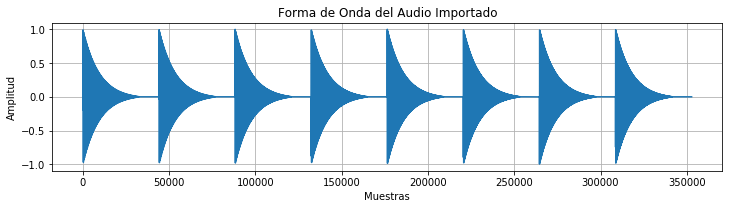

In [23]:
# Gráfica forma de onda
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(audio_data)
plt.title("Forma de Onda del Audio Importado")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid(True)
plt.show()

## Definición de funciones a utilizar

In [24]:
# Función para aplicar FFT
def apply_fft(input_data):
    """
    Aplica la Transformada Rápida de Fourier (FFT) a los datos de entrada.

    Parámetros:
    - input_data (numpy array): Datos de entrada en formato numpy array que se van a transformar.

    Devuelve:
    - Resultado de la aplicación de la FFT a los datos de entrada.
    """
    np.copyto(input_buffer_fft, input_data.astype(np.csingle))
    return fft.stream_fft(input_buffer_fft)

# Obtención de la frecuencia de mayor amplitud en cada bloque de la FFT
def get_max_amplitude_frequency(fft_result, sample_rate, max_frequency=5000):
    """
    Obtiene la frecuencia de mayor amplitud en un bloque de resultados de FFT.

    Parámetros:
    - fft_result (numpy array): Resultados de la FFT.
    - sample_rate (int): Tasa de muestreo de los datos originales.
    - max_frequency (float, opcional): Frecuencia máxima a considerar, por defecto es 5000 Hz.

    Devuelve:
    - frequency (float): Frecuencia con la mayor amplitud.
    - amplitude (float): Valor de la amplitud correspondiente a la frecuencia máxima.
    """
    # Calcular la magnitud de la FFT
    magnitudes = np.abs(fft_result)
    
    # Filtrar las frecuencias por debajo del umbral
    valid_indices = (frequencies_fft <= max_frequency)
    valid_magnitudes = magnitudes[valid_indices]
    
    # Si no hay frecuencias válidas, devolver None
    if len(valid_magnitudes) == 0:
        return 0, 0
    
    valid_frequencies = frequencies_fft[valid_indices]
    
    # Encontrar el índice de la magnitud máxima dentro de las frecuencias válidas
    max_index = np.argmax(valid_magnitudes)
    
    if abs(valid_frequencies[max_index]) > max_frequency:
        return 0, 0
    
    return abs(valid_frequencies[max_index]), valid_magnitudes[max_index]

# Función para convertir frecuencia a número de nota MIDI
def frequency_to_midi(frequency):
    """
    Convierte una frecuencia al número de nota MIDI correspondiente.

    Parámetros:
    - frequency (float): Frecuencia que se desea convertir.

    Devuelve:
    - midi_note (int): Número de nota MIDI correspondiente, o None si no se encuentra una nota correspondiente.
    """
    if frequency <= 0:
        return None

    if frequency <= 0:
        raise ValueError("Frequency must be positive.")
    
    # Buscar la nota MIDI correspondiente en el diccionario
    for midi_note, (low, mid, high) in midi_notes.items():
        if low <= frequency <= high:
            return midi_note
    
    # Si no se encuentra una nota correspondiente, devolver None
    return None

# Implementación https://github.com/NFJones/audio-to-midi/blob/master/audio_to_midi/notes.py
def generate_midi_notes():
    """
    Genera un diccionario de notas MIDI con sus correspondientes rangos de frecuencia.

    Parámetros:
    - Ninguno.

    Devuelve:
    - notes (dict): Diccionario donde las claves son los números de nota MIDI y los valores son listas con tres elementos 
    [low, mid, high] que representan el rango de frecuencias para cada nota MIDI.
    """

    # C0
    base = [7.946362749, 8.1757989155, 8.4188780665]
    
    # 12th root of 2
    multiplier = np.float_power(2.0, 1.0 / 12)

    notes = {0: base}
    for i in range(1, 128):
        mid = multiplier * notes[i - 1][1]
        low = (mid + notes[i - 1][1]) / 2.0
        high = (mid + (multiplier * mid)) / 2.0
        notes.update({i: [low, mid, high]})

    return notes

## Configuración tamaño de bloque FFT

In [25]:
# Parámetros FFT y visualización
BLOCK_SIZE = 4096 # Cantidad de samples por cada bloque de audio
block_duration = BLOCK_SIZE / SAMPLE_RATE # Duración de cada bloque en segundos
frequencies_fft = np.fft.fftfreq(BLOCK_SIZE, d=1/SAMPLE_RATE) # Obtener las frecuencias correspondientes a cada índice

# Configurar FFT
fft.configure('1', BLOCK_SIZE)

# Buffer de entrada para DMA
input_buffer_fft = allocate(shape=(BLOCK_SIZE,), dtype=np.csingle)

# Generar el diccionario de frecuencias a notas MIDI
midi_notes = generate_midi_notes()

## Cálculo FFT archivo de audio con FPGA

In [26]:
%%time

fft_results = []
max_frequencies = []
max_magnitudes = []

# Dividir el audio en bloques y aplicar FFT
for start in range(0, len(audio_data), BLOCK_SIZE):
    block = audio_data[start:start + BLOCK_SIZE]
    if len(block) < BLOCK_SIZE:
        block = np.pad(block, (0, BLOCK_SIZE - len(block)), 'constant')
    res_fft = apply_fft(block)
    
    fft_results.append(res_fft)
    
    # Obtener la frecuencia de mayor amplitud y su magnitud
    frequency, magnitude = get_max_amplitude_frequency(res_fft, SAMPLE_RATE, 5000)
    max_frequencies.append(frequency)
    max_magnitudes.append(magnitude)

CPU times: user 293 ms, sys: 0 ns, total: 293 ms
Wall time: 291 ms


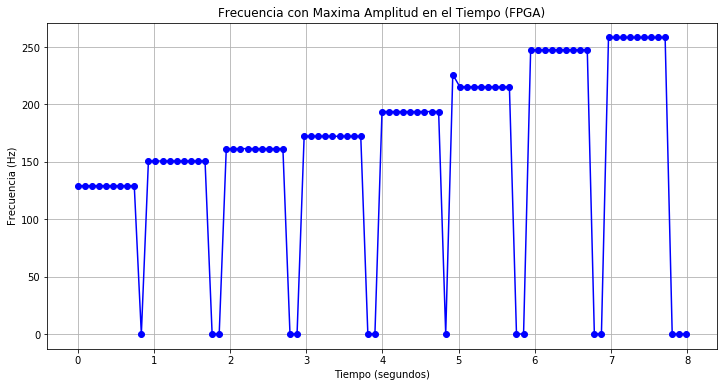

In [27]:
# Calcular el tiempo en segundos para cada bloque
block_times = [i * (block_duration) for i in range(len(max_frequencies))]

# Gráfico visualización de frecuencias en tiempo
plt.figure(figsize=(12, 6))
plt.plot(block_times, max_frequencies, marker='o', linestyle='-', color='b')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Frecuencia (Hz)')
plt.title('Frecuencia con Maxima Amplitud en el Tiempo (FPGA)')
plt.grid(True)

# Mostrar el gráfico
plt.show()

## Cálculo FFT archivo de audio con numpy

In [28]:
%%time

fft_results_numpy = []
max_frequencies_numpy = []
max_magnitudes_numpy = []

# Dividir el audio en bloques y aplicar FFT
for start in range(0, len(audio_data), BLOCK_SIZE):
    block = audio_data[start:start + BLOCK_SIZE]
    if len(block) < BLOCK_SIZE:
        block = np.pad(block, (0, BLOCK_SIZE - len(block)), 'constant')
    res_fft = np.fft.fft(block)

    
    fft_results_numpy.append(res_fft)
    
    # Obtener la frecuencia de mayor amplitud y su magnitud
    frequency, magnitude = get_max_amplitude_frequency(res_fft, SAMPLE_RATE, 5000)
    max_frequencies_numpy.append(frequency)
    max_magnitudes_numpy.append(magnitude)

CPU times: user 342 ms, sys: 0 ns, total: 342 ms
Wall time: 342 ms


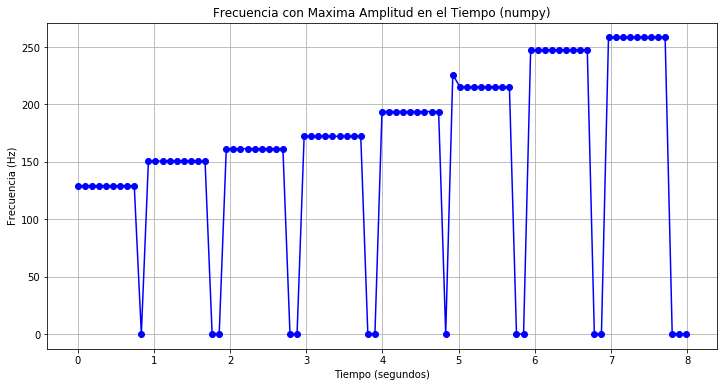

In [29]:
# Calcular el tiempo en segundos para cada bloque
block_times_numpy = [i * (block_duration) for i in range(len(max_frequencies))]

# Gráfico visualización de frecuencias en tiempo
plt.figure(figsize=(12, 6))
plt.plot(block_times_numpy, max_frequencies_numpy, marker='o', linestyle='-', color='b')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Frecuencia (Hz)')
plt.title('Frecuencia con Maxima Amplitud en el Tiempo (numpy)')
plt.grid(True)

# Mostrar el gráfico
plt.show()

## Carga de Archivo 2

In [30]:
# Cargar archivo de audio
SAMPLE_RATE, audio_data = wavfile.read("archivo2.wav")
print("Sample Rate: " + str(SAMPLE_RATE))

# Convertir a mono si es necesario
if len(audio_data.shape) > 1:
    audio_data = np.mean(audio_data, axis=1)
    
# Asegurarse de que el audio esté en formato float32
audio_data = audio_data.astype(np.float32)

# Normalizar el audio para la visualización
audio_data = audio_data / np.max(np.abs(audio_data))

Sample Rate: 44100


/usr/lib/python3/dist-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


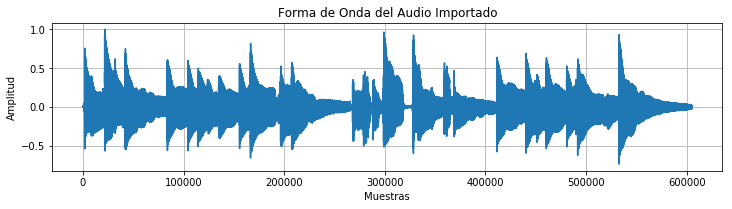

In [31]:
# Gráfica forma de onda
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(audio_data)
plt.title("Forma de Onda del Audio Importado")
plt.xlabel("Muestras")
plt.ylabel("Amplitud")
plt.grid(True)
plt.show()

## Configuración tamaño de bloque FFT

In [32]:
# Parámetros FFT y visualización
BLOCK_SIZE = 4096 # Cantidad de samples por cada bloque de audio
block_duration = BLOCK_SIZE / SAMPLE_RATE # Duración de cada bloque en segundos
frequencies_fft = np.fft.fftfreq(BLOCK_SIZE, d=1/SAMPLE_RATE) # Obtener las frecuencias correspondientes a cada índice

# Configurar FFT
fft.configure('1', BLOCK_SIZE)

# Buffer de entrada para DMA
input_buffer_fft = allocate(shape=(BLOCK_SIZE,), dtype=np.csingle)

# Generar el diccionario de frecuencias a notas MIDI
midi_notes = generate_midi_notes()

## Cálculo FFT archivo de audio con FPGA

In [41]:
%%time

fft_results = []
max_frequencies = []
max_magnitudes = []

# Dividir el audio en bloques y aplicar FFT
for start in range(0, len(audio_data), BLOCK_SIZE):
    block = audio_data[start:start + BLOCK_SIZE]
    if len(block) < BLOCK_SIZE:
        block = np.pad(block, (0, BLOCK_SIZE - len(block)), 'constant')
    res_fft = apply_fft(block)
    
    fft_results.append(res_fft)
    
    # Obtener la frecuencia de mayor amplitud y su magnitud
    frequency, magnitude = get_max_amplitude_frequency(res_fft, SAMPLE_RATE, 5000)
    max_frequencies.append(frequency)
    max_magnitudes.append(magnitude)

CPU times: user 498 ms, sys: 0 ns, total: 498 ms
Wall time: 498 ms


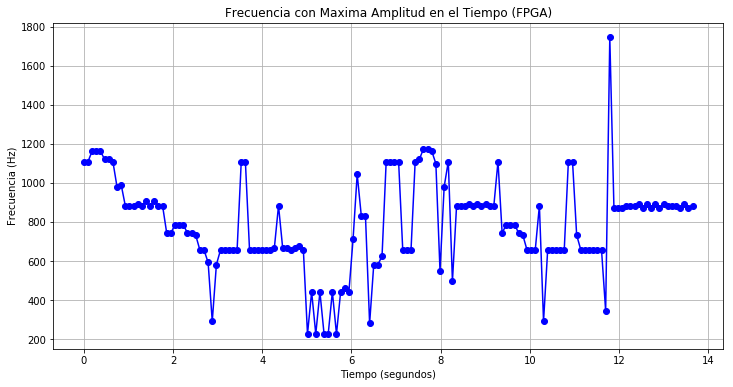

In [34]:
# Calcular el tiempo en segundos para cada bloque
block_times = [i * (block_duration) for i in range(len(max_frequencies))]

# Gráfico visualización de frecuencias en tiempo
plt.figure(figsize=(12, 6))
plt.plot(block_times, max_frequencies, marker='o', linestyle='-', color='b')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Frecuencia (Hz)')
plt.title('Frecuencia con Maxima Amplitud en el Tiempo (FPGA)')
plt.grid(True)

# Mostrar el gráfico
plt.show()

## Cálculo FFT archivo de audio con numpy

In [55]:
%%time

fft_results_numpy = []
max_frequencies_numpy = []
max_magnitudes_numpy = []

# Dividir el audio en bloques y aplicar FFT
for start in range(0, len(audio_data), BLOCK_SIZE):
    block = audio_data[start:start + BLOCK_SIZE]
    if len(block) < BLOCK_SIZE:
        block = np.pad(block, (0, BLOCK_SIZE - len(block)), 'constant')
    res_fft = np.fft.fft(block)

    
    fft_results_numpy.append(res_fft)
    
    # Obtener la frecuencia de mayor amplitud y su magnitud
    frequency, magnitude = get_max_amplitude_frequency(res_fft, SAMPLE_RATE, 5000)
    max_frequencies_numpy.append(frequency)
    max_magnitudes_numpy.append(magnitude)

CPU times: user 595 ms, sys: 0 ns, total: 595 ms
Wall time: 596 ms


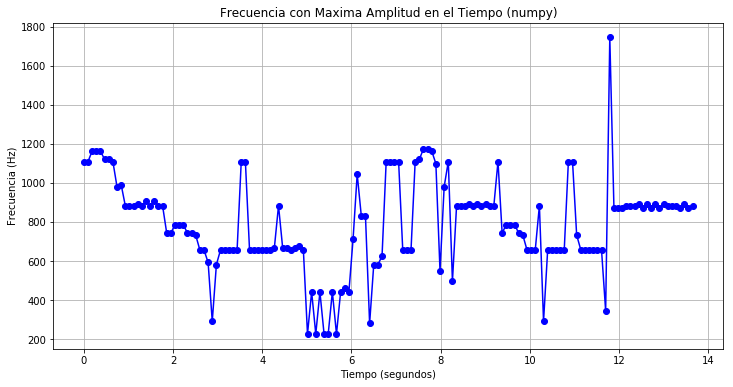

In [56]:
# Calcular el tiempo en segundos para cada bloque
block_times_numpy = [i * (block_duration) for i in range(len(max_frequencies))]

# Gráfico visualización de frecuencias en tiempo
plt.figure(figsize=(12, 6))
plt.plot(block_times_numpy, max_frequencies_numpy, marker='o', linestyle='-', color='b')
plt.xlabel('Tiempo (segundos)')
plt.ylabel('Frecuencia (Hz)')
plt.title('Frecuencia con Maxima Amplitud en el Tiempo (numpy)')
plt.grid(True)

# Mostrar el gráfico
plt.show()